# **TP 2 - Détection de menaces radar**

Cours d'*apprentissage profond et traitemet du signal MVA*

## Auteurs: 
### - *Naïl Khelifa*
### - *Quentin Moayedpour*

In [1]:
#!pip install numpy
#!pip install sklearn
#!pip install pathlib 
#!pip install xgboost

In [262]:
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from pathlib import Path
import scipy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.consignes{
  font-weight: bold;
  color: #3256a8;
  background-color: #edebdf
}
</style>
""")





<div class=consignes> Listez les noms des étudiants (2 au maximum) ayant participé à ce notebook dans la cellule suivante (prénom, nom, affectation).<br/>
Au moment du rendu, le notebook doit être nommé nom1_nom2_dlts_tp2.ipynb 

2 séances de TP sur ce sujet : le 16 octobre (1h30) et le 23 octobre (3h).<br> 
Deadline : 30 otobre 2024, 13h59, par mail à deepetsignal.mva@gmail.com <br> 

Pour installer les paquets nécessaires à la réalisation de ce TP vous pouvez utiliser dans le notebook 
    
```
!pip install \< nom_du_paquet \>
```
merci de regrouper toutes les installations dans la première cellule du notebook. 
Essayez de faire en sorte que votre notebook puisse se lire comme un compte rendu, évitez de laisser du code mort et prennez le temps de commenter vos observations et résultats.
    
## Mission


Vous commandez un avion de reconnaissance en mission top secrète. Malgré votre discretion et toutes les précautions prises vous dérangez et pouvez être sujet de menaces qu'il vous faut détecter pour garantir la sécurité de votre équipage et la succès de votre mission (comme elle est top secrète vous ne pouvez pas en savoir plus). 

A votre disposition un réseau d'antennes et un système d'analyse spectrale perfectionnés vous permettent d'extraire et de caractériser des signaux en provenance des radars à altitude 0 qui parsèment votre parcours. 

Un signal radar est composé d'impulsions. Le système d'analyse vous permettent de caractériser chaque impulsion reçue par un PDW (Pulse Description Word) qui contient: 

- la date de début de détection de l'impulsion (en ms)
- la largeur ou durée de l'impulsion (en ms)
- la puissance de l'impulsion (en dB / référence) 
- l'angle theta et l'angle phi décrivant la direction dans laquelle l'impulsion est détectée (en radians)
- la fréquence de l'impulsion (en Ghz)

Votre capteur n'est pas parfait et vous subissez notamment un phénomène de mitage: une certaine proportion des impulsions émises ne sont pas détectées. Cette proportion est d'autant plus grande que la puissance des impulsions est petite.  

Votre vaisseau navigue à 10 km d'altitude, avec une vitesse constante de 1000 km/h vers le nord. 

De précédentes missions ont permis de réaliser une base de données de signaux de 10 secondes. 
Chaque signal se présente sous la forme d'un fichier .npz qui contient l'ensemble des PDW reçus. 

Un signal est donc un fichier dont le nom est de la forme 'pdw_<numéro du signal>.npz'.

Cette base de données est annotée: le destin de chaque mission a permis de déclarer chaque signal comme une 'menace' ou une 'nonmenace'. 

Les signaux ont été divisés en deux ensembles indépendants: 
    
- train
- test 
 
Les annotations pour chaque ensemble sont disponibles dans le fichier labels_<train ou test>.json qui donne l'association nom de fichier -> menace ou nonmenace. 
    
    
Votre mission (si vous l'acceptez) est de choisir et d'entrainer un algorithme d'apprentissage machine à détecter les menaces sur l'ensemble 'train' et à évaluer ses performances sur l'ensemble 'test'. 

Fort de votre expérience passée, vous décidez de suivre la méthodologie suivante: 

- Visualisation et analyse des données pour trouver les paramètres les plus pertinents à utiliser 
- Sélection d'un algorithme naïf "baseline" de référence: vous définissez un premier algorithme simple et caractérisez ses performances qui serviront de point de comparaison pour qualifier l'apport d'algorithmes plus sophistiqués 
- Vous utilisez la bibliothèque sklearn et notamment ses implémentations d'algorithmes de classification binaire pour définir et entrainer sur l'ensemble 'train' un ou plusieurs algorithmes en capacité de prédire le label menance ou nonmenace de chaque signal (https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- Vous qualifiez les performances de vos algorithmes en termes d'accuracy (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) ; vous calculez aussi les matrices de confusion (https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix)
    
Pour ce TP nous ne cherchons pas à mettre en place des algorithmes d'apprentissage profond. Ces méthodes pourront être investiguées dans un deuxième temps.
    
 Si les résultats vous semblent décevants, souvenez vous des conseils de votre prédecesseur et mentor G. Abitbol: "toujours donner un coup de pouce à un algo de machine learning  en lui présentant les bonnes données"

Vous pouvez ouvrir un fichier de la façon suivante:

</div>    

In [4]:
pdws = np.load('./radars/train/pdw-0.npz')
dates = pdws['date']
largeurs = pdws['largeur']
frequences=pdws['frequence']
puissances = pdws['puissance']
theta = pdws['theta']
phi = pdws['phi']

<div class=consignes> et les fichiers d'annotations:</div>

In [5]:
import json

with open('./radars/train_labels.json') as f: 
    dict_labels = json.load(f)
nonmenace_train, menace_train = [], []

for key, values in dict_labels.items():
    if values == 'nonmenace':
        nonmenace_train.append(key)
    else:
        menace_train.append(key)

<div class=consignes> On compte sur vous, bonne chance ! </div>

# Sommaire

## - [Préparation des Données](#travail-sur-les-données)
## - [Analyse Exploratoire](#visualisation-des-données-et-étude-des-features-intéressante)
## - [Modèles et prédiction](#modèles-et-prédiction)



La meilleure accuracy obtenue dans ce travail est de `85.56%` avec des forêts aléatoires, talonnée par la régression logistique et des arbres de décision qui atteignent `82%`.

## 1. **Travail sur les données**

En observant les données, on se rend compte que l'échantillonnage n'est pas régulier ce qui complique le travail pour celles-ci. Pour remédier à ce problème, on se propose de réechantillonner le tout, avec une **fréquence d'échantillonnage** de 10 Hz.

On commence par définir la fonction `data_transformation` qui effectue ces transformations sur les données 

In [235]:
def calculate_residuals(X, y):
    """
    Calcule les résidus de `y_var` par rapport à `x_var` via une régression linéaire.
    
    Parameters:
    - df: DataFrame contenant les données.
    - x_var: Nom de la variable explicative (par défaut 'frequence').
    - y_var: Nom de la variable dépendante (par défaut 'largeur').
    
    Returns:
    - residuals: Série des résidus de `y_var` par rapport à `x_var`.
    """
    # Ajout d'une constante pour l'interception dans le modèle
    X = sm.add_constant(X)

    # Régression linéaire
    model = sm.OLS(y, X).fit()

    # Calcul des résidus
    beta = model.params[0]
    
    return beta

def data_transformation(source="train", sample_count=400):
    """Normalizes and standardizes the dataset.
    
    Parameters:
    - source (str): The source dataset. Default is "train_set".
    - sample_count (int): Number of samples for the regular timeline. Default is 200.
    
    Returns:
    pd.DataFrame: A DataFrame with the standardized dataset.
    """
    features = []  # List to store transformed records
    measurement_units = [  # Measurement units and their scale factors
        ("largeur", 1.E-3),
        ("frequence", 1.E9),
        ("puissance", 1.), 
        ("theta", 1.),
        ("phi", 1.)
    ]
    
    # Open the JSON file containing labels associated with the data
    with open('./radars/' + f'{source}_labels.json') as file:
        dict_labels = json.load(file)  # Load labels into a dictionary

    # Loop through each data point (800 points in the test set)
    for index in range(800):
        # Load data from an .npz file
        data_points = np.load('./radars/' + source + f'/pdw-{index}.npz')
        
        # Check if the data point is considered non-threatening
        is_non_threat = dict_labels[f'pdw-{index}'] == "nonmenace"
        
        # Retrieve timestamps
        timestamps = data_points['date']
        
        # Create a regular timeline with the specified sample count
        uniform_times = np.linspace(0, 10.E3, sample_count)
        features_dataset = {}  # Dictionary to store transformed values for this point

        # Normalize the values of each measurement
        for measurement, scale in measurement_units:
            non_uniform_values = data_points[measurement]  # Non-uniform values
            # Interpolate to get sampled values on the regular timeline
            resampled_values = np.interp(uniform_times, xp=timestamps, fp=non_uniform_values)
            features_dataset[measurement] = resampled_values * scale  # Apply scale factor

        # Indicate whether the point is threatening or not in the record
        features_dataset["menace"] = not is_non_threat
        
        # Calculate time intervals between timestamps
        time_intervals = (timestamps[1:] - timestamps[:-1]) / 1000.  # Convert to seconds
        # Calculate the ratio of time intervals relative to the smallest interval
        features_dataset["time_intervals_ratio"] = np.round(time_intervals / np.min(time_intervals))
        # Calculate impulse frequency
        features_dataset["impulse_frequency"] = 1. / np.min(time_intervals)

        #  max, min, mean et écart-type de la frequence et de la puissance
        features_dataset["max_frequency"] = np.max(data_points['frequence'])
        features_dataset["min_frequency"] = np.min(data_points['frequence'])
        features_dataset["std_frequency"] = np.std(data_points['frequence'])
        features_dataset["average_frequency"] = np.mean(data_points["frequence"])
        features_dataset["average_puissance"] = np.mean(data_points["frequence"])/np.mean(data_points["puissance"])
        features_dataset["beta"] = calculate_residuals(data_points['largeur'], data_points['frequence'])
        features_dataset["average_largeur"] = np.mean(data_points["largeur"])
        delta_theta = np.diff(data_points["theta"])
        delta_phi = np.diff(data_points["phi"])
        features_dataset["angular_distances"] = np.sqrt(delta_theta**2 + delta_phi**2)
        features_dataset["angular_concentration"] = np.abs(np.mean(np.exp(1j * (data_points["theta"] + data_points["phi"]))))
        features_dataset["freq_duration_ratio"] = (features_dataset["impulse_frequency"] * features_dataset["average_largeur"])/np.abs(np.max(data_points["puissance"]))
        features.append(features_dataset)  # Add the transformed record to the list

    # Conversion of the list of records to DataFrame
    standardized_df = pd.DataFrame.from_dict(features)
    return standardized_df

def identify_peaks(data_frame, include_in_df):
    """
    Identifies peaks in the 'puissance' column of the given DataFrame.
    
    Parameters:
    data_frame (pd.DataFrame): The DataFrame containing data to analyze.
    include_in_df (bool): If True, adds the locations and values of the peaks to the DataFrame. Default is False.
    
    Returns:

    Tuple[List, List]: A tuple containing two lists:
                       - List of peak locations for each signal.
                       - List of peak values for each signal.
    """
    # Iterate over two cases: find peaks above and below a certain threshold
    for is_below_threshold, label_prefix in [(True, "below_"), (False, "")]:
        peak_indices_list = []  # To store indices of detected peaks
        peak_values_list = []   # To store values of detected peaks

        # Iterate over each row of the DataFrame
        for index in range(len(data_frame)):
            # Find peaks in the 'puissance' column, inverting the signal for the below-threshold case
            peaks = scipy.signal.find_peaks((-1 if is_below_threshold else 1.) * data_frame['puissance'][index])[0]
            peak_indices_list.append(peaks)  # Add the indices of the peaks
            peak_values_list.append(data_frame['puissance'][index][peaks])  # Add the corresponding peak values

        # Include peak information in the original DataFrame if specified
        if include_in_df:
            data_frame[label_prefix + "peak_indices"] = peak_indices_list
            data_frame[label_prefix + "peak_values"] = peak_values_list
            data_frame[label_prefix + "peak_average"] = [values.mean() if len(values) > 0 else 0 for values in peak_values_list]

    return peak_indices_list, peak_values_list  # Return lists of indices and values of the peaks


On a ajouté dans le dataset plusieurs features intuitifs obtenus à l'aide de transformations sur les données initiales, notamment :

- des features statistiques de base : `max_frequency`, `min_frequency`, `std_frequency`, `mean_frequency` et pareil pour la puissance et la largeur
- des features un peu plus développés, notamment les pics dans les puissances dans la routine `identify_peaks`
- des features directionnelles avec `angular_distance` et `angular_concentration`
- la fréquence d'impulsion avec `impulse_frequency` et une variante exotique donné par le ratio fréquence-duration dans `freq_duration_ratio`

L'idée de la partie suivante de visualisation va justement être de déterminer quels features expliquent le plus de variance et sont les plus pertinents. On charge au préalable dans la variable `df_train`le dataset pertinent.

In [236]:
df_train = data_transformation(source="train")
df_test = data_transformation(source="test")
identify_peaks(data_frame=df_train, include_in_df=True)
identify_peaks(data_frame=df_test, include_in_df=True)
df_train.head(5)

,largeur,frequence,puissance,theta,phi,menace,time_intervals_ratio,impulse_frequency,max_frequency,min_frequency,...,average_largeur,angular_distances,angular_concentration,freq_duration_ratio,below_peak_indices,below_peak_values,below_peak_average,peak_indices,peak_values,peak_average
0,"[0.00029099999999999997, 0.0002910131198921446...","[2222011346.301772, 2188838332.4664564, 221013...","[-125.58248735699023, -133.15092494028025, -13...","[0.9578859532471261, 0.7760393895131867, 0.735...","[1.678935775441994, 1.8038056774441733, 1.4550...",False,"[16.0, 8.0, 20.0, 26.0, 12.0, 1.0, 26.0, 4.0, ...",677.048070,2.238800,2.178543,...,0.292003,"[0.222443399213105, 0.4285618073844664, 0.2573...",0.894287,1.835545,"[2, 12, 16, 21, 27, 34, 46, 59, 65, 77, 85, 94...","[-137.84616359196008, -136.0303146791062, -134...",-160.588430,"[7, 14, 19, 24, 30, 40, 51, 64, 66, 84, 86, 10...","[-107.76917779557884, -120.3783770562251, -125...",-145.072266
1,"[0.00013800000000000002, 0.0001379225368717744...","[3011221070.570557, 3006113254.3097525, 300583...","[-127.176799666022, -127.30693997644518, -131....","[2.7962717807754327, 2.9787680716468254, -2.86...","[1.5296932038533972, 1.7114331652475727, 1.299...",False,"[17.0, 6.0, 7.0, 10.0, 2.0, 35.0, 25.0, 55.0, ...",1092.896175,3.031234,2.946963,...,0.137017,"[0.3578679156588335, 0.1262917283418571, 0.124...",0.965002,1.177455,"[6, 16, 32, 39, 53, 56, 67, 77, 81, 84, 93, 10...","[-168.6705800924423, -136.4724313700351, -171....",-156.529946,"[12, 17, 35, 52, 54, 57, 76, 80, 82, 85, 102, ...","[-134.28888204934026, -136.43026562019415, -15...",-147.509845
2,"[0.000201, 0.00020192647161441566, 0.000201092...","[991990464.3038368, 986182083.7883215, 9824160...","[-149.880060930416, -150.70280063317094, -151....","[-2.0412578355641227, -1.7921445090328343, -2....","[1.6722396416013094, 1.6371981722139965, 1.654...",True,"[15.0, 5.0, 3.0, 1.0, 2.0, 41.0, 1.0, 20.0, 13...",634.517766,0.997647,0.972759,...,0.201962,"[0.2715310438683405, 0.03421662365602879, 0.07...",0.976628,0.878519,"[9, 12, 20, 38, 53, 68, 83, 89, 97, 111, 118, ...","[-154.45785143050963, -156.28615791967664, -18...",-185.570812,"[10, 13, 30, 44, 61, 74, 88, 90, 104, 117, 119...","[-154.2325442477705, -156.28374475876956, -159...",-165.487746
3,"[6.800000000000001e-05, 6.801633761855428e-05,...","[1666424017.2021985, 1679998510.8052545, 16669...","[-135.68775777002037, -134.87153347964633, -13...","[-2.621701006244045, -2.4245550030013234, -2.3...","[1.4039557266900524, 1.5094252424671166, 1.590...",False,"[16.0, 3.0, 2.0, 2.0, 8.0, 15.0, 6.0, 23.0, 10...",1466.275660,1.691682,1.640058,...,0.069014,"[0.41670436395018545, 0.48754794563263776, 0.2...",0.966082,0.763760,"[4, 8, 11, 17, 20, 23, 28, 32, 36, 40, 43, 49,...","[-134.57543779947224, -135.37191566417678, -13...",-148.664863,"[3, 6, 9, 12, 19, 21, 25, 29, 33, 37, 41, 44, ...","[-134.03476205382532, -134.14883128529007, -13...",-144.347899
4,"[0.000324, 0.000324, 0.000324, 0.0003241794697...","[2207809393.1871147, 2206753627.9569974, 21935...","[-172.60362010919195, -171.77174470072956, -16...","[2.274032092616462, 2.2747120350886147, 2.2832...","[1.6134753329852611, 1.5842763143629524, 1.219...",False,"[17.0, 1.0, 4.0, 5.0, 25.0, 27.0, 1.0, 21.0, 2...",604.960678,2.229983,2.182394,...,0.324018,"[0.409680242373368, 0.5749010250926617, 0.0622...",0.922705,1.321060,"[8, 12, 18, 23, 35, 37, 41, 44, 46, 48, 53, 55...","[-154.1301552015464, -158.9075187011074, -166....",-178.667104,"[6, 10, 15, 20, 29, 36, 38, 42, 45, 47, 49, 54...","[-149.81188454013804, -150.03771201169502, -15...",-170.053987


On crée enfin deux sous-dataframe pour obtenir les valeurs associées à une menace et ceux qui ne le sont pas 

In [237]:
# Séparer les menaces
df_menaces_train = df_train[df_train['menace'] == True]

# Séparer les non-menaces
df_non_menaces_train = df_train[df_train['menace'] == False]

## 2. **Visualisation des données et recherche des features pertinentes**

L'idée est pour nous d'étudier la répartition de chaque feature dans chaque sous population labelisée comme une menace ou non pour trouver un feature d'intérêt. Cela nous permettra d'entraîner un modèle, même naïf.

Une première approche est de faire deux SVD, l'une sur la population menace et l'autre sur la population non-menace puis d'observer quel features expliquent le plus de variance. 

On espère ainsi observer des différence d'importance de features.

                 Feature  Explained Variance - Non-menace
0        average_largeur                         0.499227
1          max_frequency                         0.190119
2          min_frequency                         0.132813
3          std_frequency                         0.124591
4                   beta                         0.052325
5  angular_concentration                         0.000642
6    freq_duration_ratio                         0.000280
7     below_peak_average                         0.000002
                 Feature  Explained Variance - Menace
0        average_largeur                     0.335727
1          max_frequency                     0.194866
2          min_frequency                     0.140521
3          std_frequency                     0.116647
4                   beta                     0.106888
5  angular_concentration                     0.054887
6    freq_duration_ratio                     0.050459
7     below_peak_average                     0

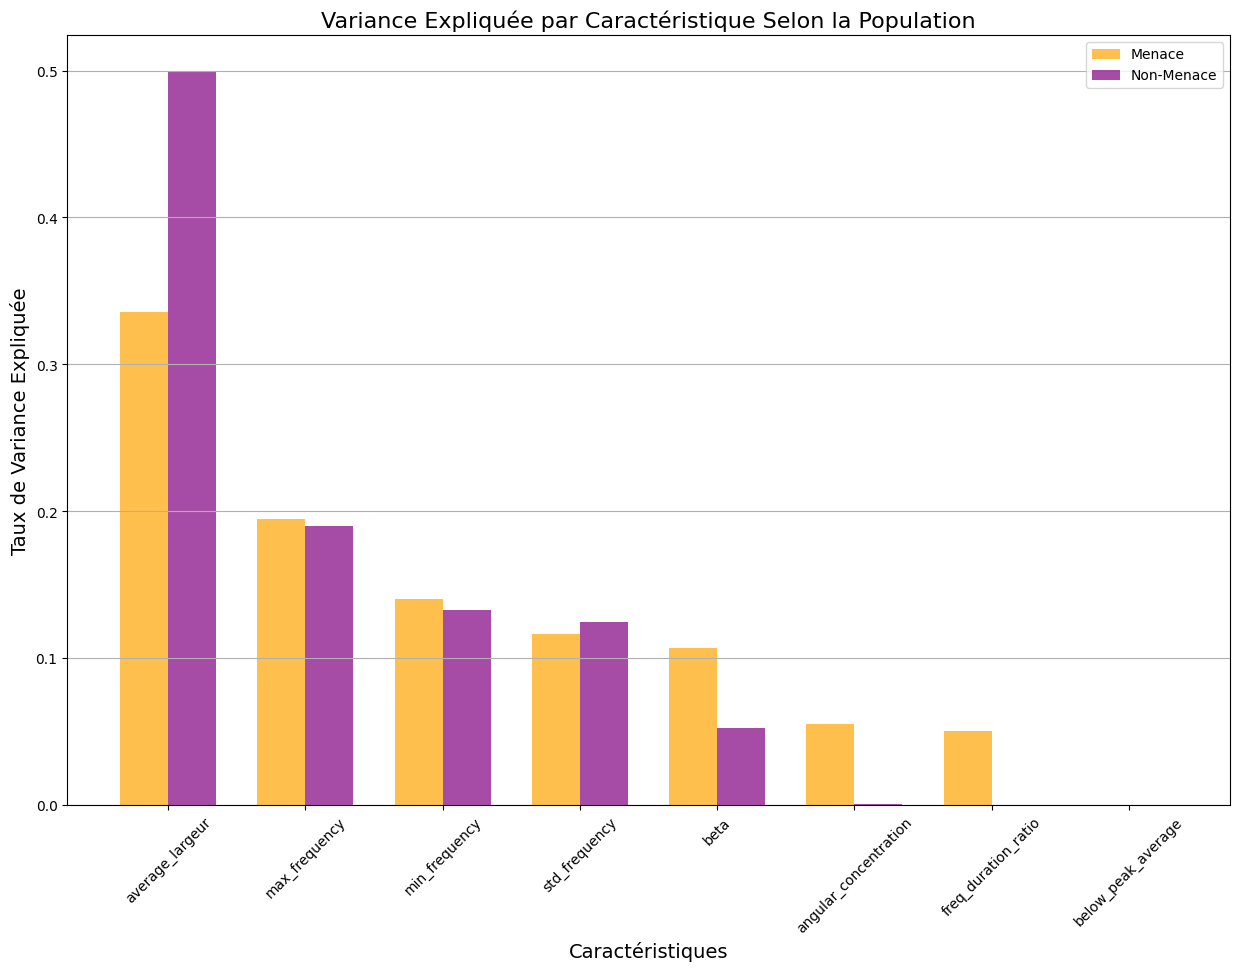

In [238]:
# Création d'une figure et d'un axe pour le graphique
fig, ax = plt.subplots(figsize=(15, 10))

# Liste des caractéristiques à analyser
features_list = ['average_largeur', 'max_frequency', 'min_frequency', 'std_frequency', 'beta',
                 'angular_concentration', 'freq_duration_ratio', 'below_peak_average']

X_menace = df_menaces_train[features_list]
X_non_menace = df_non_menaces_train[features_list]

# Normalisation des données
scaler = StandardScaler()
X_scaled_non_menace = scaler.fit_transform(X_non_menace)
X_scaled_menace = scaler.fit_transform(X_menace)

# Exécution de la SVD
U_menace, S_menace, VT_menace = np.linalg.svd(X_scaled_menace, full_matrices=False)
U_non_menace, S_non_menace, VT_non_menace = np.linalg.svd(X_scaled_non_menace, full_matrices=False)

# Calcul de la variance expliquée
explained_variance_menace = (S_menace**2) / np.sum(S_menace**2)
explained_variance_non_menace = (S_non_menace**2) / np.sum(S_non_menace**2)

# Création d'un DataFrame pour associer les caractéristiques avec leur variance expliquée
explained_variance_df_menace = pd.DataFrame({
    'Feature': features_list,
    'Explained Variance - Menace': explained_variance_menace[:len(features_list)]
})

explained_variance_df_non_menace = pd.DataFrame({
    'Feature': features_list,
    'Explained Variance - Non-menace': explained_variance_non_menace[:len(features_list)]
})

# Tri des DataFrames par variance expliquée
explained_variance_df_non_menace.sort_values(by='Explained Variance - Non-menace', ascending=False, inplace=True)
explained_variance_df_menace.sort_values(by='Explained Variance - Menace', ascending=False, inplace=True)

# Affichage des variances expliquées triées
print(explained_variance_df_non_menace)
print(explained_variance_df_menace)

# Position des barres pour chaque feature
x = np.arange(len(features_list))
width = 0.35  # Largeur des barres pour les mettre côte à côte

# Barres pour la menace
ax.bar(x - width/2, explained_variance_df_menace['Explained Variance - Menace'], 
       width, color='orange', alpha=0.7, label='Menace')

# Barres pour la non-menace
ax.bar(x + width/2, explained_variance_df_non_menace['Explained Variance - Non-menace'], 
       width, color='purple', alpha=0.7, label='Non-Menace')

# Titre et labels du graphique
ax.set_title('Variance Expliquée par Caractéristique Selon la Population', fontsize=16)
ax.set_xlabel('Caractéristiques', fontsize=14)
ax.set_ylabel('Taux de Variance Expliquée', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(features_list, rotation=45)  # Rotation des étiquettes de l'axe des x pour faciliter la lecture
ax.grid(axis='y')  # Affichage de la grille sur l'axe des y
ax.legend()  # Affichage de la légende


On peut se dire que le feature **largeur** est intéressant ici, puisque c'est l'un des seuls dont l'écart d'explication de variance est significatif d'un groupe à l'autre. Les features `beta`, `angular_concentration` et `freq_duration_ratio` sont également intéressants.

On complète cette approche en comparant les valeurs moyennes de chaque features dans chaque population. 

/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_29119/1856299074.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='menace', y=var, data=df_train, palette=['skyblue', 'salmon'])
/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_29119/1856299074.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='menace', y=var, data=df_train, palette=['skyblue', 'salmon'])
/var/folders/kd/c_69_lv95n33jqfn1l50n0ww0000gn/T/ipykernel_29119/1856299074.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='menace', y=var, data=df_train,

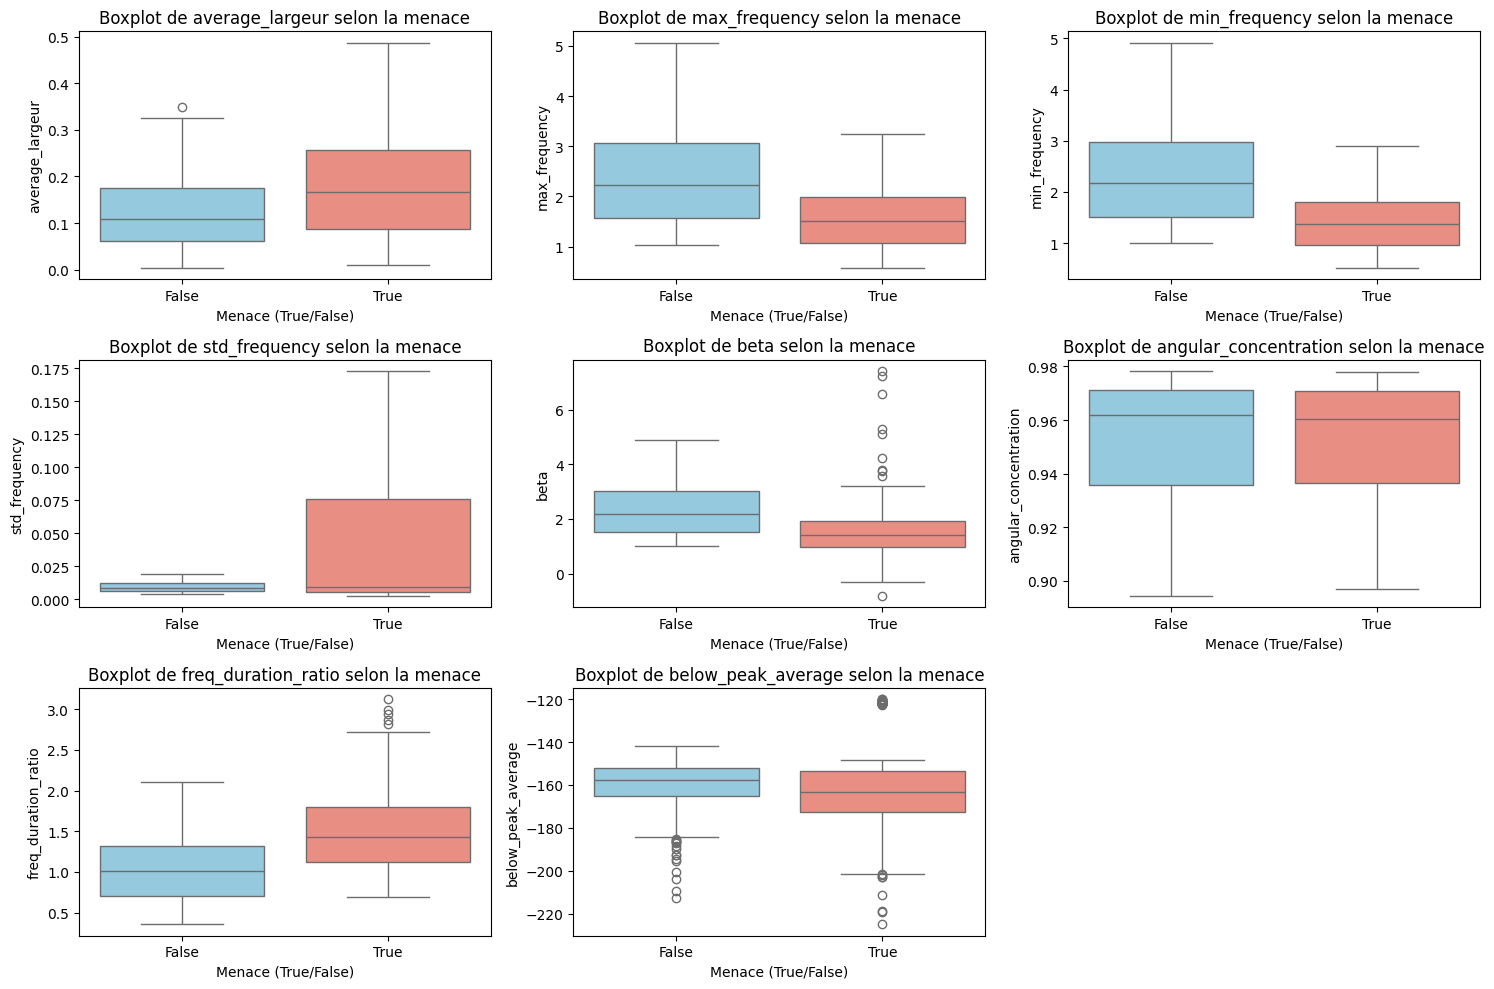

In [239]:
# Variables à tracer
features_list = ['average_largeur', 'max_frequency', 'min_frequency', 'std_frequency', 'beta',
                 'angular_concentration', 'freq_duration_ratio', 'below_peak_average']

# Tracer les boxplots pour chaque variable en fonction de la menace
plt.figure(figsize=(15, 10))
for i, var in enumerate(features_list):
    plt.subplot(3, 3, i+1)  # Deux lignes, deux colonnes
    sns.boxplot(x='menace', y=var, data=df_train, palette=['skyblue', 'salmon'])
    plt.title(f'Boxplot de {var} selon la menace')
    plt.ylabel(var)
    plt.xlabel('Menace (True/False)')

plt.tight_layout()
plt.show()

On observe que les boxplots associés aux features `max_frequency`, `min_frequency`, `freq_duration_ratio`, `average_largeur`, `beta`et `std_frequency` sont décalés (en moyenne et en écarts-types). On se propose donc d'approfondir la visualisation avec des histogrammes.

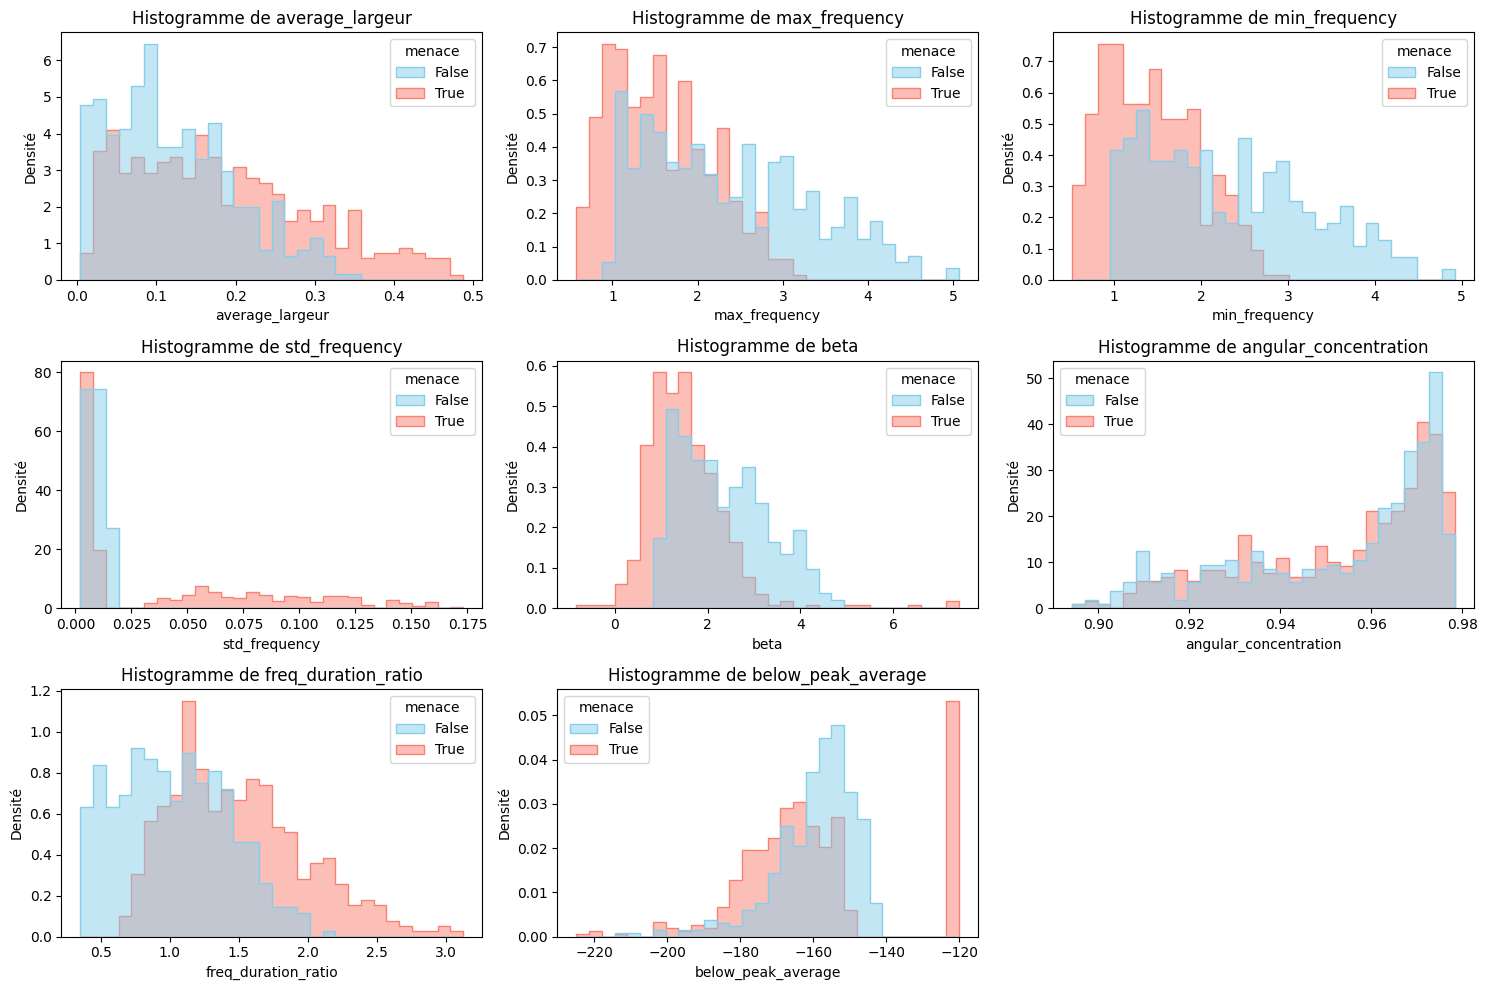

In [240]:
# Tracer les histograms
plt.figure(figsize=(15, 10))
for i, var in enumerate(features_list):
    plt.subplot(3, 3, i + 1)  # Deux lignes, trois colonnes
    sns.histplot(data=df_train, x=var, hue='menace', element='step', stat='density', common_norm=False, 
                 palette=['skyblue', 'salmon'], bins=30, alpha=0.5)
    plt.title(f'Histogramme de {var}')
    plt.ylabel('Densité')
    plt.xlabel(var)

plt.tight_layout()
plt.show()

On observe que les histogrammes associés aux features `max_frequency`, `min_frequency`, `freq_duration_ratio`, `average_largeur`, `beta`et `std_frequency` définissent deux populations qui peuvent être différenciées. On les retiens.

## 3. **Modèles et prédiction**

L'idée est de tester les différents modèles, pour obtenir des précisions optimales dans nos prédictions. 

On se propose de tester plusieurs algorithmes : 

1. des **arbres de décisions** à profondeurs variables et sur un nombre variable de features 
2. un modèle de **régression logistique** sur un nombre variable de features
3. des modèles de mélange gaussiens, cette idée nous vient cette fois-ci de la distribution des features qu'on observe dans la partie précédente.

Notre manière de sélectionner les features consiste à se donner une liste de features (colonne des datasets sur lesquels on travaille) `['average_largeur', 'max_frequency', 'min_frequency', 'std_frequency', 'beta', 'angular_concentration', 'freq_duration_ratio', 'below_peak_average']` et que l'on a classés par ordre d'importance au vu des boxplots, des histogrammes et des SVDs effectuées précedemment. L'idée est ensuite pour nous de faire varier un paramètre `max_feature` qui nous indique le nombre de features que l'on retient. 

Par exemple, si `max_feature=3` alors le modèle considérera `['average_largeur', 'max_frequency', 'min_frequency']`.

### 3.1. *Arbres de décision*

In [244]:
features_list = ['average_largeur', 'max_frequency', 'freq_duration_ratio', 'min_frequency', 'std_frequency', 
                 'beta', 'angular_concentration', 'below_peak_average']

def Tree_classifier(df_train, df_test, features_list, max_features=None):
    # Liste de couleurs pour les graphes
    color_options = "rgbckyp"
    
    train_labels = df_train['menace']
    test_labels = df_test['menace']
    
    # Définir le nombre de features maximum
    max_features = max_features if max_features is not None else len(features_list)

    # Profondeurs d'arbres de décision à tester (1 à 9)
    depth_values = list(range(1, 15))
    
    # Création d'une figure unique pour tout afficher
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.suptitle("Comparaison de l'Accuracy optimale pour différents nombres de features", fontsize=16)

    best_accuracy_arr = []

    # Boucle sur le nombre de features utilisés
    for num_features in range(1, max_features + 1):
        # Réduction des données aux `num_features` premières dimensions
        train_data = df_train[features_list[:num_features]]
        test_data = df_test[features_list[:num_features]]
        
        # Liste pour stocker les précisions obtenues pour chaque profondeur
        accuracy_scores = []

        # Boucle pour tester différents niveaux de profondeur d'arbre de décision
        for depth in depth_values:
            # Initialiser un classifieur d'arbre de décision avec une profondeur maximale spécifique
            classifier = DecisionTreeClassifier(max_depth=depth)
            
            # Entraîner le modèle sur les données d'entraînement
            classifier.fit(train_data, train_labels)
            
            # Prédictions pour les ensembles d'entraînement et de test
            train_predictions = classifier.predict(train_data)
            test_predictions = classifier.predict(test_data)
            
            # Calcul de la précision pour les données d'entraînement et de test
            train_accuracy = accuracy_score(train_labels, train_predictions)
            test_accuracy = accuracy_score(test_labels, test_predictions)
            
            # Stocker les précisions dans la liste
            accuracy_scores.append([train_accuracy, test_accuracy])
        
        # Convertir les scores en un tableau NumPy pour faciliter l'analyse
        accuracy_scores = np.array(accuracy_scores)

        # Trouver la profondeur ayant donné la meilleure précision pour le test
        best_depth_index = np.argmax(accuracy_scores[:, 1])
        best_accuracy = accuracy_scores[best_depth_index, 1]
        
        # Tracer les courbes de précision pour chaque profondeur de l'arbre
        color_choice = color_options[(num_features - 1) % len(color_options)]
        ax.plot(depth_values, accuracy_scores[:, 1], "-" + color_choice, alpha=0.7,
                 label=f"Test Accuracy {num_features} features")
        ax.plot(depth_values, accuracy_scores[:, 0], "--" + color_choice, alpha=0.5,
                 label=f"Train Accuracy {num_features} features")
        
        # Marquer la meilleure profondeur pour chaque nombre de features
        ax.plot(depth_values[best_depth_index], best_accuracy, 'o', color=color_choice, markersize=8,
                label=f"Meilleure accuracy avec {num_features} features")
        
        best_accuracy_arr.append((best_depth_index, num_features, best_accuracy))

    sorted_best_accuracy = sorted(best_accuracy_arr, key=lambda x: x[2])

    overall_best_accuracy = sorted_best_accuracy[-1]

    # Réglage des étiquettes, de la grille et de la légende
    ax.set_xlabel("Profondeur de l'arbre de décision", fontsize=14)
    ax.set_ylabel("Précision du classifieur", fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    ax.legend(loc="best", fontsize=10)
    plt.show()

    print(f"Meilleure précision = {overall_best_accuracy[2]};  pour {overall_best_accuracy[1]} features et une profondeur de {overall_best_accuracy[0] + 1}")

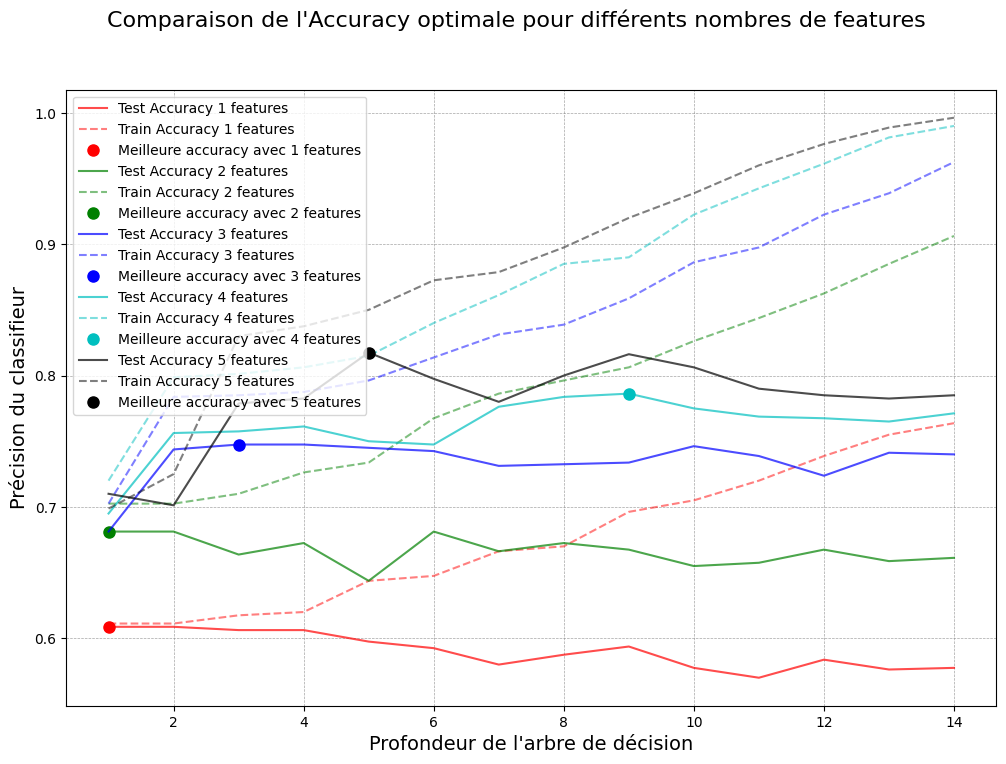

Meilleure précision = 0.8175;  pour 5 features et une profondeur de 5


In [245]:
Tree_classifier(df_train=df_train, 
                 df_test=df_test,
                 features_list=features_list,
                 max_features=5)

## 3.2. *Régression logistique*


Rapport de Classification pour 1 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.64      0.63      0.64       415
      menace       0.61      0.62      0.62       385

    accuracy                           0.63       800
   macro avg       0.63      0.63      0.63       800
weighted avg       0.63      0.63      0.63       800


Rapport de Classification pour 2 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.77      0.63      0.69       415
      menace       0.67      0.80      0.73       385

    accuracy                           0.71       800
   macro avg       0.72      0.71      0.71       800
weighted avg       0.72      0.71      0.71       800


Rapport de Classification pour 3 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.77      0.73      0.75       415
      menace       0.72      0.77      0.74       385

    accuracy                           0.

/Users/badis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/badis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l


Rapport de Classification pour 9 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.83      0.81      0.82       415
      menace       0.80      0.82      0.81       385

    accuracy                           0.81       800
   macro avg       0.81      0.81      0.81       800
weighted avg       0.81      0.81      0.81       800



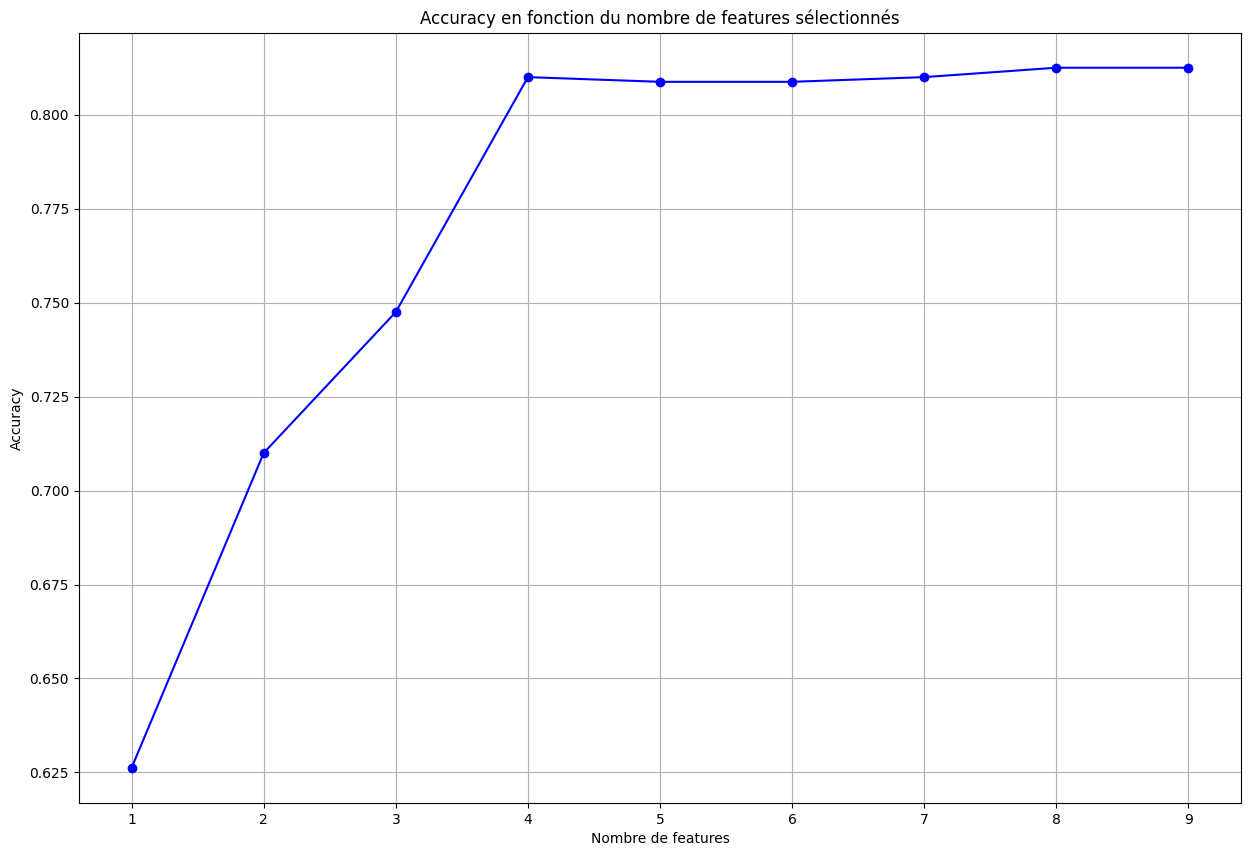

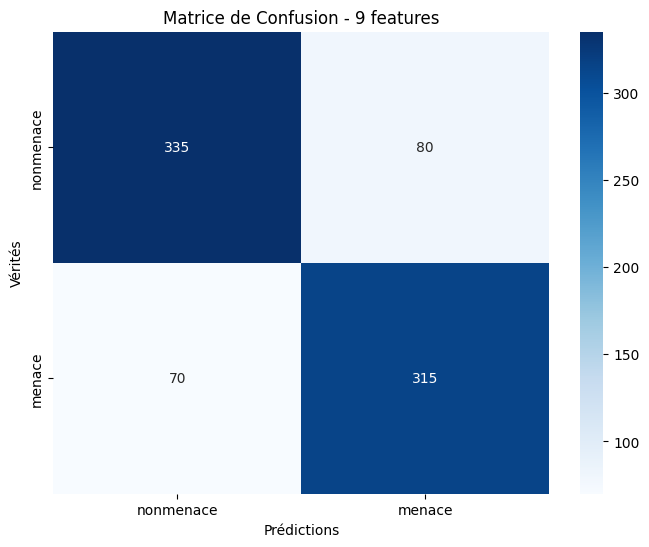

Meilleure précision = 0.8125


[0.62625, 0.71, 0.7475, 0.81, 0.80875, 0.80875, 0.81, 0.8125, 0.8125]

In [246]:
def Logistic_classifier(df_train, df_test, feature_list, max_features=3):
    train_labels = df_train['menace']
    test_labels = df_test['menace']
    
    accuracies = []
    
    # Boucle pour tester avec différents nombres de features
    for num_features in range(1, max_features + 1):
        # Sélectionner les premières `num_features` features
        selected_features = feature_list[:num_features]
        
        train_data = df_train[selected_features]
        test_data = df_test[selected_features]
        
        # Initialiser le classifieur de régression logistique
        classifier = LogisticRegression()
        
        # Entraîner le modèle
        classifier.fit(train_data, train_labels)
        
        # Prédire les labels sur l'ensemble de test
        test_predictions = classifier.predict(test_data)
        
        # Calculer l'accuracy et l'ajouter à la liste
        accuracy = accuracy_score(test_labels, test_predictions)
        accuracies.append(accuracy)
        
        # Afficher le rapport de classification pour chaque nombre de features
        print(f"\nRapport de Classification pour {num_features} feature(s) :")
        print(classification_report(test_labels, test_predictions, target_names=['nonmenace', 'menace']))
        
    # Tracer l'accuracy en fonction du nombre de features
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(range(1, max_features + 1), accuracies, marker='o', color='b')
    ax.set_title("Accuracy en fonction du nombre de features sélectionnés")  # Utilisez ax.set_title
    ax.set_xlabel("Nombre de features")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    
    # Matrice de confusion pour le dernier modèle (avec max_features)
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['nonmenace', 'menace'], yticklabels=['nonmenace', 'menace'])
    plt.title(f"Matrice de Confusion - {max_features} features")
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.show()

    print(f"Meilleure précision = {max(accuracies)}")

    return accuracies



Logistic_classifier(df_train=df_train, 
                    df_test=df_test,
                    feature_list=features_list,
                    max_features=9)

## 3.3. *Modèles de mélange*


Rapport de Classification pour 1 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.34      0.18      0.24       415
      menace       0.41      0.61      0.49       385

    accuracy                           0.39       800
   macro avg       0.37      0.40      0.36       800
weighted avg       0.37      0.39      0.36       800


Rapport de Classification pour 2 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.35      0.43      0.39       415
      menace       0.19      0.14      0.16       385

    accuracy                           0.29       800
   macro avg       0.27      0.29      0.28       800
weighted avg       0.27      0.29      0.28       800


Rapport de Classification pour 3 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.32      0.37      0.34       415
      menace       0.18      0.15      0.16       385

    accuracy                           0.

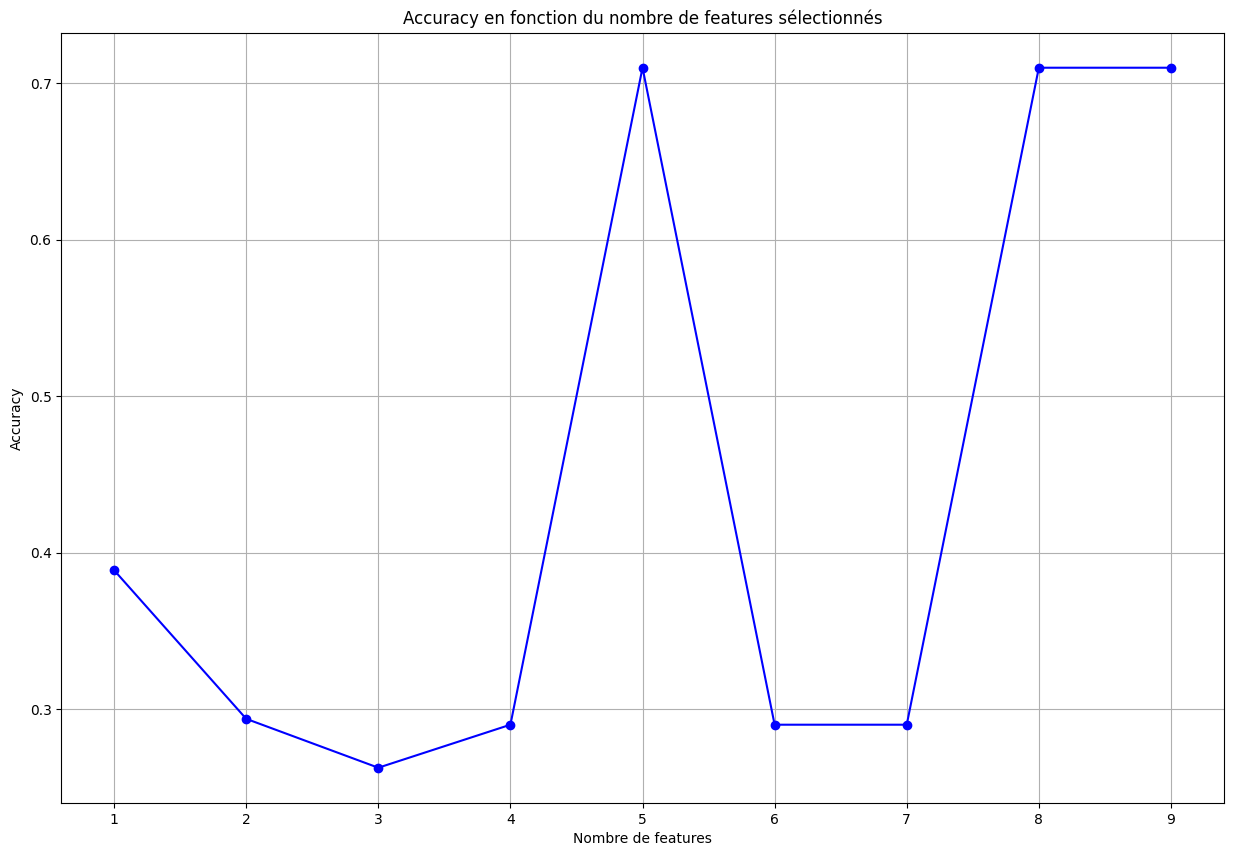

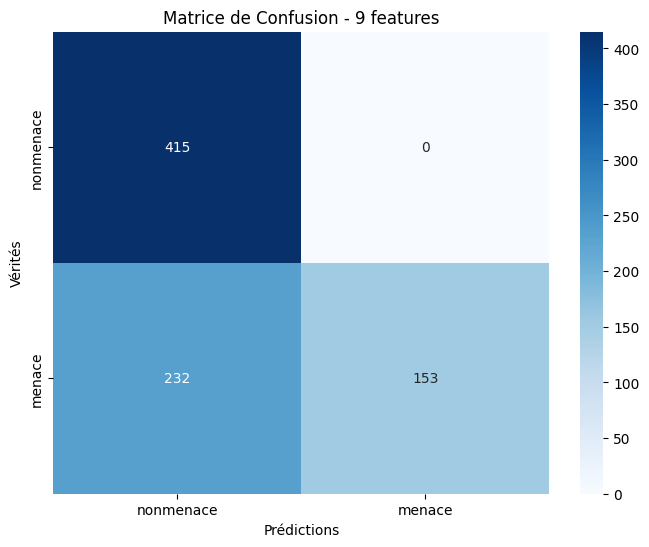

Meilleure précision = 0.71


[0.38875, 0.29375, 0.2625, 0.29, 0.71, 0.29, 0.29, 0.71, 0.71]

In [252]:
def Mixture_model_classifier(df_train, df_test, feature_list, num_components, max_features=3):

    test_labels = df_test['menace']
    
    accuracies = []
    
    # Boucle pour tester avec différents nombres de features
    for num_features in range(1, max_features + 1):
        # Sélectionner les premières `num_features` features
        selected_features = feature_list[:num_features]
        
        train_data = df_train[selected_features]
        test_data = df_test[selected_features]

        # Initialiser le classifieur de régression logistique
        classifier = GaussianMixture(n_components=num_components, covariance_type='full', random_state=42)
        
        # Entraîner le modèle
        classifier.fit(train_data)
        
        # Prédire les labels sur l'ensemble de test
        test_predictions = np.argmax(classifier.predict_proba(test_data), axis=1)

        # Calculer l'accuracy et l'ajouter à la liste
        accuracy = accuracy_score(test_labels, test_predictions)
        accuracies.append(accuracy)
        
        # Afficher le rapport de classification pour chaque nombre de features
        print(f"\nRapport de Classification pour {num_features} feature(s) :")
        print(classification_report(test_labels, test_predictions, target_names=['nonmenace', 'menace']))
        
    # Tracer l'accuracy en fonction du nombre de features
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(range(1, max_features + 1), accuracies, marker='o', color='b')
    ax.set_title("Accuracy en fonction du nombre de features sélectionnés")  # Utilisez ax.set_title
    ax.set_xlabel("Nombre de features")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    
    # Matrice de confusion pour le dernier modèle (avec max_features)
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['nonmenace', 'menace'], yticklabels=['nonmenace', 'menace'])
    plt.title(f"Matrice de Confusion - {max_features} features")
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.show()

    print(f"Meilleure précision = {max(accuracies)}")

    return accuracies

Mixture_model_classifier(df_train=df_train, 
                         df_test=df_test,
                         feature_list=features_list,
                         num_components=2,
                         max_features=9)

## 3.4. *Forêts aléatoires*


Rapport de Classification pour 1 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.57      0.55      0.56       415
      menace       0.53      0.55      0.54       385

    accuracy                           0.55       800
   macro avg       0.55      0.55      0.55       800
weighted avg       0.55      0.55      0.55       800


Rapport de Classification pour 2 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.72      0.65      0.69       415
      menace       0.66      0.73      0.69       385

    accuracy                           0.69       800
   macro avg       0.69      0.69      0.69       800
weighted avg       0.69      0.69      0.69       800


Rapport de Classification pour 3 feature(s) :
              precision    recall  f1-score   support

   nonmenace       0.76      0.70      0.73       415
      menace       0.71      0.77      0.73       385

    accuracy                           0.

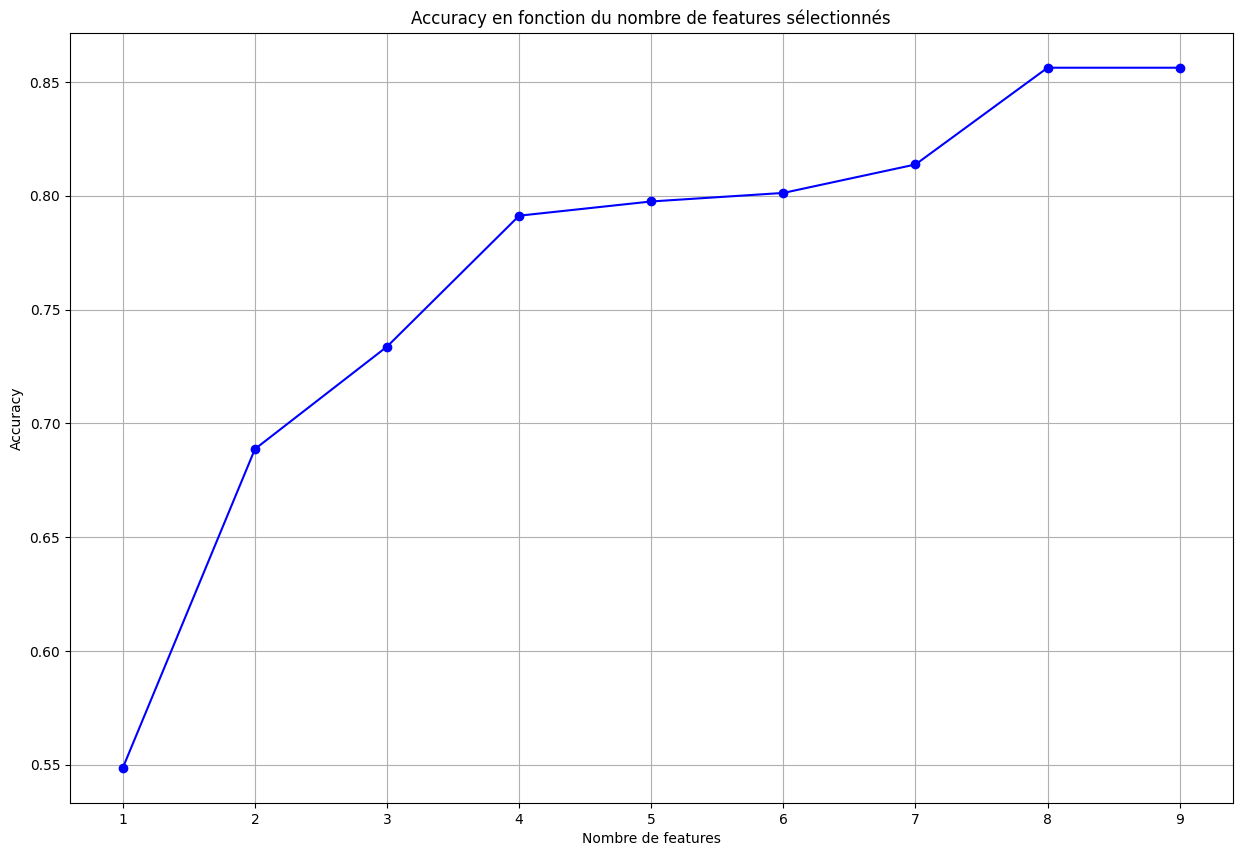

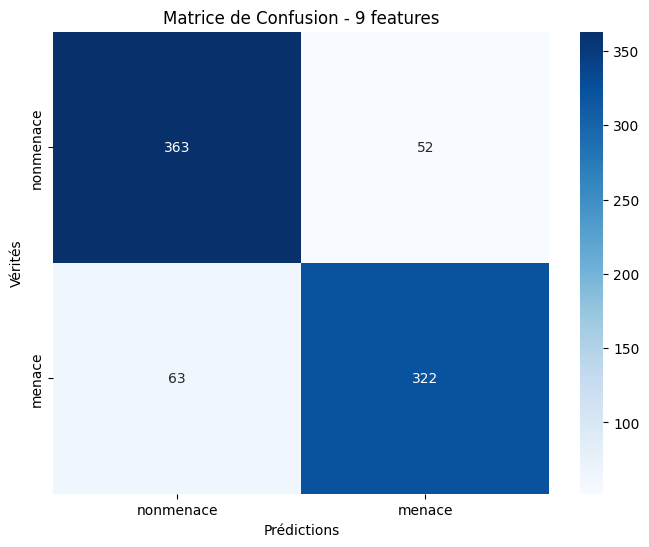

Meilleure précision = 0.85625


In [257]:
def RandomForest_classifier(df_train, df_test, feature_list, max_features=3):
    train_labels = df_train['menace']
    test_labels = df_test['menace']
    
    accuracies = []
    
    # Boucle pour tester avec différents nombres de features
    for num_features in range(1, max_features + 1):
        # Sélectionner les premières `num_features` features
        selected_features = feature_list[:num_features]
        
        train_data = df_train[selected_features]
        test_data = df_test[selected_features]

        # Initialiser le classifieur Random Forest
        classifier = RandomForestClassifier(random_state=42)
        
        # Entraîner le modèle
        classifier.fit(train_data, train_labels)
        
        # Prédire les labels sur l'ensemble de test
        test_predictions = classifier.predict(test_data)

        # Calculer l'accuracy et l'ajouter à la liste
        accuracy = accuracy_score(test_labels, test_predictions)
        accuracies.append(accuracy)
        
        # Afficher le rapport de classification pour chaque nombre de features
        print(f"\nRapport de Classification pour {num_features} feature(s) :")
        print(classification_report(test_labels, test_predictions, target_names=['nonmenace', 'menace']))
        
    # Tracer l'accuracy en fonction du nombre de features
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(range(1, max_features + 1), accuracies, marker='o', color='b')
    ax.set_title("Accuracy en fonction du nombre de features sélectionnés")
    ax.set_xlabel("Nombre de features")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    
    # Matrice de confusion pour le dernier modèle (avec max_features)
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['nonmenace', 'menace'], yticklabels=['nonmenace', 'menace'])
    plt.title(f"Matrice de Confusion - {max_features} features")
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.show()

    print(f"Meilleure précision = {max(accuracies)}")

RandomForest_classifier(df_train=df_train, 
                        df_test=df_test,
                        feature_list=features_list,
                        max_features=9)

## 3.5. *Gradient boosting*

In [275]:
def GradientBoosting_classifier(df_train, df_test, feature_list, max_features=3):
    train_labels = df_train['menace']
    test_labels = df_test['menace']
    
    accuracies = []
    
    # Boucle pour tester avec différents nombres de features
    for num_features in range(1, max_features + 1):
        # Sélectionner les premières `num_features` features
        selected_features = feature_list[:num_features]
        
        train_data = df_train[selected_features]
        test_data = df_test[selected_features]

        # Initialiser le classifieur XGBoost
        classifier = GradientBoostingClassifier()
        
        # Entraîner le modèle
        classifier.fit(train_data, train_labels)
        
        # Prédire les labels sur l'ensemble de test
        test_predictions = classifier.predict(test_data)

        # Calculer l'accuracy et l'ajouter à la liste
        accuracy = accuracy_score(test_labels, test_predictions)
        accuracies.append(accuracy)
        
        # Afficher le rapport de classification pour chaque nombre de features
        print(f"\nRapport de Classification pour {num_features} feature(s) :")
        print(classification_report(test_labels, test_predictions, target_names=['nonmenace', 'menace']))
        
    # Tracer l'accuracy en fonction du nombre de features
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.plot(range(1, max_features + 1), accuracies, marker='o', color='b')
    ax.set_title("Accuracy en fonction du nombre de features sélectionnés")
    ax.set_xlabel("Nombre de features")
    ax.set_ylabel("Accuracy")
    ax.grid(True)

    
    # Matrice de confusion pour le dernier modèle (avec max_features)
    cm = confusion_matrix(test_labels, test_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['nonmenace', 'menace'], yticklabels=['nonmenace', 'menace'])
    plt.title(f"Matrice de Confusion - {max_features} features")
    plt.xlabel('Prédictions')
    plt.ylabel('Vérités')
    plt.show()

    print(f"Meilleure précision = {max(accuracies)}")

    return accuracies

GradientBoosting_classifier(df_train=df_train, 
               df_test=df_test,
               feature_list=features_list,
               max_features=9)

TypeError: GradientBoostingClassifier() missing 3 required positional arguments: 'df_train', 'df_test', and 'feature_list'